### step 0: install packages

In [ ]:
!pip install -q datasets transformers accelerate evaluate torch torchvision scikit-learn matplotlib


### step 1: imports

In [ ]:
import os, random, json, numpy as np
from collections import Counter, defaultdict

import datasets
from datasets import load_dataset

import torch
from torch.utils.data import WeightedRandomSampler
from transformers import (
    AutoImageProcessor, ViTForImageClassification,
    TrainingArguments, Trainer, set_seed
)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt


### Step 2 — Load dataset (CelebA) and pick a balanced-ish subset

In [ ]:
set_seed(42)
ds = load_dataset("flwrlabs/celeba")


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

img_align+identity+attr/train-00000-of-0(…):   0%|          | 0.00/500M [00:00<?, ?B/s]

img_align+identity+attr/train-00001-of-0(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

img_align+identity+attr/train-00002-of-0(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

img_align+identity+attr/train-00003-of-0(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

img_align+identity+attr/train-00004-of-0(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

img_align+identity+attr/train-00005-of-0(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

img_align+identity+attr/train-00006-of-0(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

img_align+identity+attr/train-00007-of-0(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

img_align+identity+attr/train-00008-of-0(…):   0%|          | 0.00/497M [00:00<?, ?B/s]

img_align+identity+attr/train-00009-of-0(…):   0%|          | 0.00/503M [00:00<?, ?B/s]

img_align+identity+attr/train-00010-of-0(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

img_align+identity+attr/train-00011-of-0(…):   0%|          | 0.00/501M [00:00<?, ?B/s]

img_align+identity+attr/train-00012-of-0(…):   0%|          | 0.00/494M [00:00<?, ?B/s]

img_align+identity+attr/train-00013-of-0(…):   0%|          | 0.00/504M [00:00<?, ?B/s]

img_align+identity+attr/train-00014-of-0(…):   0%|          | 0.00/490M [00:00<?, ?B/s]

img_align+identity+attr/train-00015-of-0(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

img_align+identity+attr/train-00016-of-0(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

img_align+identity+attr/train-00017-of-0(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

img_align+identity+attr/train-00018-of-0(…):   0%|          | 0.00/489M [00:00<?, ?B/s]

img_align+identity+attr/valid-00000-of-0(…):   0%|          | 0.00/388M [00:00<?, ?B/s]

img_align+identity+attr/valid-00001-of-0(…):   0%|          | 0.00/385M [00:00<?, ?B/s]

img_align+identity+attr/valid-00002-of-0(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

img_align+identity+attr/test-00000-of-00(…):   0%|          | 0.00/391M [00:00<?, ?B/s]

img_align+identity+attr/test-00001-of-00(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

img_align+identity+attr/test-00002-of-00(…):   0%|          | 0.00/383M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/162770 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/19867 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19962 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

### Step 3: inspect the dataset

In [ ]:
# Basic dataset info
print(ds)  # shows splits and size

# Show dataset schema (columns and datatypes)
print(ds["train"].features)

# Peek at one sample
print("One sample:\n", ds["train"][0])

# Show first 3 identities
for i in range(3):
    print("ID:", ds["train"][i]['celeb_id'], "Image:", ds["train"][i]["image"])

# Convert a slice to pandas to get familiar .info() output
import pandas as pd
df = pd.DataFrame(ds["train"][:1000])   # just first 1000 rows
print(df.info())
print(df.head())

# Count how many unique identities exist in CelebA
id_counts = Counter(map(int, ds["train"]['celeb_id']))
print("Number of unique identities in CelebA:", len(id_counts))
print("Top 10 most common identities:", id_counts.most_common(10))


DatasetDict({
    train: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 162770
    })
    valid: Dataset({
        features: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'H

### Step 4: Filter CelebA to balanced subset

In [ ]:

# Combine all splits (easier for custom stratified split)
full = datasets.concatenate_datasets([ds["train"], ds["valid"], ds["test"]])

# Count images per identity
id_counts = Counter(map(int, full["celeb_id"]))

MAX_IDS = 20
most_common = id_counts.most_common(MAX_IDS)
chosen_ids = set([cid for cid, cnt in most_common])

subset = full.filter(lambda ex: int(ex["celeb_id"]) in chosen_ids)
#  u can replace it with a faster option:
# subset = full.filter(
#     lambda batch: [int(x) in chosen_ids for x in batch["celeb_id"]],
#     batched=True,
#     num_proc=4   # Colab: 2–4 is safe; 8 if you want max CPU
# )
# or this(the fastest)

# subset = full.filter(
#     lambda batch: [int(x) in chosen_ids for x in batch["celeb_id"]],
#     batched=True,
#     num_proc=4   # Colab: 2–4 is safe; 8 if you want max CPU
# )


print(f"Chosen {len(chosen_ids)} identities, {len(subset)} images total")
print("Top chosen IDs (with counts):", most_common)


Chosen 20 identities, 638 images total
Top chosen IDs (with counts): [(2820, 35), (3227, 35), (3782, 35), (3699, 34), (3745, 34), (8968, 32), (9152, 32), (9256, 32), (1757, 31), (2114, 31), (4126, 31), (4262, 31), (4887, 31), (6568, 31), (9840, 31), (4740, 31), (4978, 31), (14, 30), (15, 30), (17, 30)]


### Step 5: Map celeb_id to contiguous labels

In [ ]:
unique_ids = sorted(list(chosen_ids))
id2label = {cid: i for i, cid in enumerate(unique_ids)}
label2id = {i: cid for cid, i in id2label.items()}

def add_label(example):
    example["label"] = id2label[int(example["celeb_id"])]
    return example

subset = subset.map(add_label, desc="Adding label indices")
print("Columns:", subset.column_names)
print("Example:", subset[0]["label"], "celeb_id:", subset[0]["celeb_id"])


Adding label indices:   0%|          | 0/638 [00:00<?, ? examples/s]

Columns: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'label']
Example: 0 celeb_id: 14


### Step 6: Stratified split (80/10/10)

In [ ]:
import random
from collections import defaultdict, Counter
import numpy as np

def stratified_split(dataset, label_col="label", train_p=0.8, val_p=0.1, test_p=0.1, seed=42):
    random.seed(42)
    by_label = defaultdict(list)
    for i, y in enumerate(dataset[label_col]):
        by_label[int(y)].append(i)

    train_idx, val_idx, test_idx = [], [], []
    for y, idxs in by_label.items():
        random.shuffle(idxs)
        n = len(idxs)
        n_train = int(n * train_p)
        n_val   = int(n * val_p)
        train_idx += idxs[:n_train]
        val_idx   += idxs[n_train:n_train+n_val]
        test_idx  += idxs[n_train+n_val:]
    return dataset.select(train_idx), dataset.select(val_idx), dataset.select(test_idx)

train_ds, val_ds, test_ds = stratified_split(subset)
print("sizes :", len(train_ds), len(val_ds), len(test_ds))


sizes : 501 60 77


### Step 7: split summaries

In [ ]:
from collections import Counter
import numpy as np

def split_summary(name, d):
    c = Counter(map(int, d["label"]))
    vals = list(c.values())
    return {
        "name": name,
        "rows": len(d),
        "num_classes": len(c),
        "min_per_class": min(vals) if vals else 0,
        "median_per_class": int(np.median(vals)) if vals else 0,
        "max_per_class": max(vals) if vals else 0,
    }

print(split_summary("train", train_ds))
print(split_summary("val",   val_ds))
print(split_summary("test",  test_ds))

ex = train_ds[0]
print(f"Sample → label={ex['label']} (celeb_id={label2id[ex['label']]}); image type={type(ex['image'])}")


{'name': 'train', 'rows': 501, 'num_classes': 20, 'min_per_class': 24, 'median_per_class': 24, 'max_per_class': 28}
{'name': 'val', 'rows': 60, 'num_classes': 20, 'min_per_class': 3, 'median_per_class': 3, 'max_per_class': 3}
{'name': 'test', 'rows': 77, 'num_classes': 20, 'min_per_class': 3, 'median_per_class': 4, 'max_per_class': 4}
Sample → label=0 (celeb_id=14); image type=<class 'PIL.PngImagePlugin.PngImageFile'>


### Step 8: preprocessing for ViT

In [ ]:
# Step 8 — Preprocessing via a data collator (no with_transform)

import torch
from transformers import AutoImageProcessor

MODEL_NAME = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

def vision_processor_collate(examples):
    # examples are raw rows: {"image": PIL.Image, "label": int, ...}
    images = [ex["image"].convert("RGB") for ex in examples]
    labels = torch.tensor([int(ex["label"]) for ex in examples], dtype=torch.long)
    enc = processor(images=images, return_tensors="pt")
    enc["labels"] = labels
    return enc

# Keep RAW datasets; collator will do all preprocessing at batch time
train_ds_tf = train_ds
val_ds_tf   = val_ds
test_ds_tf  = test_ds

num_labels = len(unique_ids)
print("num_labels:", num_labels)

# Sanity: collate a tiny batch
_batch_test = vision_processor_collate([train_ds_tf[0], train_ds_tf[1]])
print("pixel_values batch shape:", tuple(_batch_test["pixel_values"].shape))  # (B, 3, 224, 224)
print("labels batch shape:", tuple(_batch_test["labels"].shape))


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

num_labels: 20
pixel_values batch shape: (2, 3, 224, 224)
labels batch shape: (2,)


In [ ]:
# Inspect a few raw items from each split to see available keys
def show_keys(dset, name):
    ex0 = dset[0]
    print(f"{name} keys:", list(ex0.keys()))
    if "image" in ex0:
        print(f"{name} sample image type:", type(ex0["image"]))
    if "pixel_values" in ex0:
        print(f"{name} sample pixel_values shape:", tuple(ex0["pixel_values"].shape))
    if "label" in ex0:
        print(f"{name} sample label:", ex0["label"])
    if "labels" in ex0:
        print(f"{name} sample labels:", ex0["labels"])

show_keys(train_ds_tf, "train_ds_tf")
show_keys(val_ds_tf,   "val_ds_tf")


train_ds_tf keys: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'label']
train_ds_tf sample image type: <class 'PIL.PngImagePlugin.PngImageFile'>
train_ds_tf sample label: 0
val_ds_tf keys: ['image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goate

###Step 9: Train ViT on your 20 identities

In [ ]:
# Cell — Rebuild args with remove_unused_columns=False and train again

from transformers import TrainingArguments, Trainer, ViTForImageClassification, AutoImageProcessor
import torch, transformers

print("Transformers version:", transformers.__version__)

MODEL_NAME = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

def smart_vision_collate(examples):
    if isinstance(examples, dict):
        examples = [examples]
    if "image" in examples[0]:
        images = [ex["image"].convert("RGB") for ex in examples]
        labels = torch.tensor([int(ex["label"]) for ex in examples], dtype=torch.long)
        enc = processor(images=images, return_tensors="pt")
        enc["labels"] = labels
        return enc
    if "pixel_values" in examples[0]:
        pixel_values = torch.stack([ex["pixel_values"] for ex in examples])
        labels = torch.tensor([int(ex.get("labels", ex["label"])) for ex in examples], dtype=torch.long)
        return {"pixel_values": pixel_values, "labels": labels}
    raise KeyError(f"Batch missing both 'image' and 'pixel_values': {list(examples[0].keys())}")

# Recreate/ensure model exists
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(set(train_ds_tf["label"])),
    id2label={i: str(i) for i in range(len(set(train_ds_tf["label"])))},
    label2id={str(i): i for i in range(len(set(train_ds_tf["label"])))},
    ignore_mismatched_sizes=True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {"accuracy": float((preds == labels).mean())}

args = TrainingArguments(
    output_dir="./faceguard_vit_celebA",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=25,
    fp16=torch.cuda.is_available(),
    report_to="none",
    remove_unused_columns=False,   # <-- critical: keep 'image' so collator can see it
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds_tf,
    eval_dataset=val_ds_tf,
    data_collator=smart_vision_collate,
    compute_metrics=compute_metrics,
)

trainer.train()


Transformers version: 4.56.1


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.655400,1.753255,0.633333
2,1.444400,1.054578,0.916667
3,0.777900,0.708252,0.933333
4,0.247200,0.622331,0.933333


TrainOutput(global_step=128, training_loss=1.0832154513336718, metrics={'train_runtime': 197.1107, 'train_samples_per_second': 10.167, 'train_steps_per_second': 0.649, 'total_flos': 1.553190004971602e+17, 'train_loss': 1.0832154513336718, 'epoch': 4.0})

### Step 10: Evaluate on test set (accuracy + classification report)

In [48]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# 1) run inference on the test split using the same Trainer+collator
pred_out = trainer.predict(test_ds_tf)   # returns predictions, labels, metrics (loss)

# 2) unpack
logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = logits.argmax(-1)

# 3) metrics
test_acc = accuracy_score(y_true, y_pred)
print("TEST accuracy:", f"{test_acc:.4f}")
print("\nClassification report (per-class precision/recall/F1):\n")
print(classification_report(y_true, y_pred, digits=4))


TEST accuracy: 0.8312

Classification report (per-class precision/recall/F1):

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         3
           1     0.6000    1.0000    0.7500         3
           2     0.7500    1.0000    0.8571         3
           3     1.0000    0.7500    0.8571         4
           4     1.0000    0.2500    0.4000         4
           5     0.8000    1.0000    0.8889         4
           6     1.0000    0.7500    0.8571         4
           7     1.0000    1.0000    1.0000         4
           8     1.0000    1.0000    1.0000         4
           9     0.7500    0.7500    0.7500         4
          10     1.0000    1.0000    1.0000         4
          11     1.0000    0.5000    0.6667         4
          12     1.0000    1.0000    1.0000         4
          13     1.0000    0.7500    0.8571         4
          14     1.0000    0.7500    0.8571         4
          15     0.6667    1.0000    0.8000         4
  

### Step 11: Confusion Matrix for Test Set

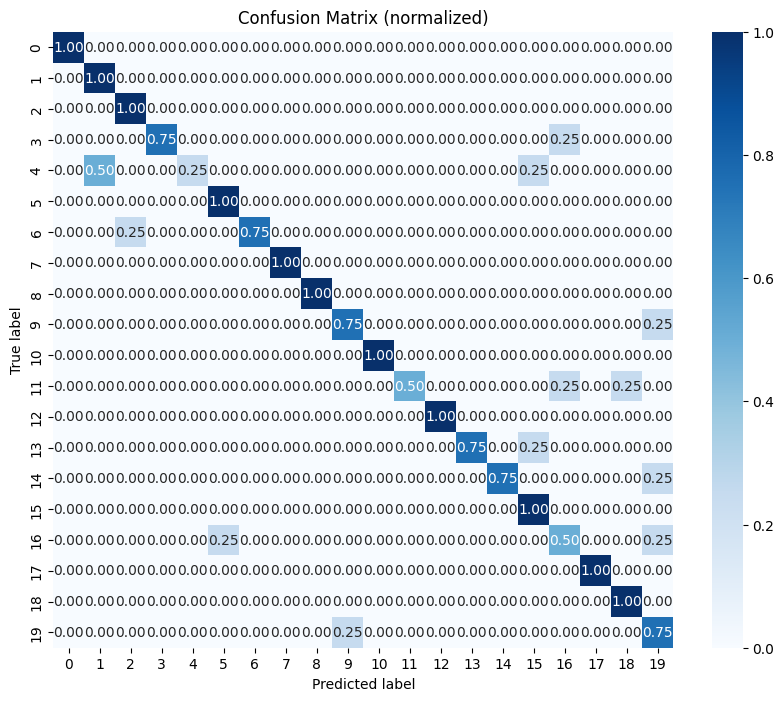

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1) build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 2) normalize per row (optional: easier to read)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# 3) plot
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[str(i) for i in range(num_labels)],
            yticklabels=[str(i) for i in range(num_labels)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (normalized)")
plt.show()


### Step 12: ROC curves and AUC for multi-class

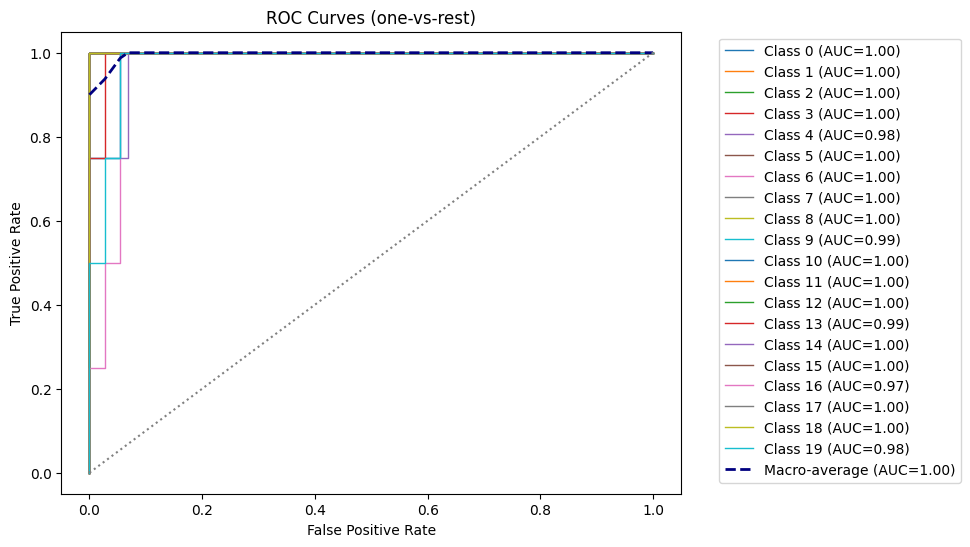

In [51]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1) One-hot encode the true labels for ROC
y_true_bin = label_binarize(y_true, classes=list(range(num_labels)))

# 2) Get class probabilities from logits
y_prob = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

# 3) Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4) Macro-average ROC (all classes equally)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_labels
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# 5) Plot ROC curves
plt.figure(figsize=(8,6))
for i in range(num_labels):
    plt.plot(fpr[i], tpr[i], lw=1,
             label=f"Class {i} (AUC={roc_auc[i]:.2f})")
plt.plot(all_fpr, mean_tpr, color="navy", linestyle="--",
         label=f"Macro-average (AUC={roc_auc['macro']:.2f})", lw=2)
plt.plot([0,1],[0,1], color="gray", linestyle=":")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (one-vs-rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


### Step 13 : Save confusion matrix, ROC, and metrics for the README/Space

In [52]:
import os, json
from datetime import datetime

ART_DIR = "artifacts_faceguard"
os.makedirs(ART_DIR, exist_ok=True)

# 1) Save confusion matrix (re-plot quickly, normalized)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,8))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
cm_path = os.path.join(ART_DIR, "confusion_matrix_test.png")
plt.savefig(cm_path, dpi=160)
plt.close()

# 2) Save ROC plot (uses variables from Cell 12)
plt.figure(figsize=(8,6))
for i in range(num_labels):
    plt.plot(fpr[i], tpr[i], lw=1, label=f"Class {i} (AUC={roc_auc[i]:.2f})")
plt.plot(all_fpr, mean_tpr, linestyle="--", lw=2, label=f"Macro (AUC={roc_auc['macro']:.2f})")
plt.plot([0,1],[0,1], linestyle=":")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OvR)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
roc_path = os.path.join(ART_DIR, "roc_curves_test.png")
plt.tight_layout()
plt.savefig(roc_path, dpi=160)
plt.close()

# 3) Save a metrics JSON (handy for README/model card)
summary = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "model_name": "google/vit-base-patch16-224",
    "num_labels": int(num_labels),
    "train_images": int(len(train_ds)),
    "val_images": int(len(val_ds)),
    "test_images": int(len(test_ds)),
    "val_best_accuracy": float(trainer.state.best_metric) if trainer.state.best_metric is not None else None,
    "test_accuracy": float(test_acc),
    "macro_auc": float(roc_auc["macro"]),
}
metrics_path = os.path.join(ART_DIR, "metrics.json")
with open(metrics_path, "w") as f:
    json.dump(summary, f, indent=2)

# 4) Save label mapping (for readable inference/README)
id2label_json = {str(i): str(label2id[i]) for i in range(num_labels)}
with open(os.path.join(ART_DIR, "id2label.json"), "w") as f:
    json.dump(id2label_json, f, indent=2)

print("Saved:")
print(" -", cm_path)
print(" -", roc_path)
print(" -", metrics_path)
print(" -", os.path.join(ART_DIR, "id2label.json"))


Saved:
 - artifacts_faceguard/confusion_matrix_test.png
 - artifacts_faceguard/roc_curves_test.png
 - artifacts_faceguard/metrics.json
 - artifacts_faceguard/id2label.json


/tmp/ipython-input-1764187088.py:40: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


### Step 14: Top-5 predictions (pretty print + quick visual)

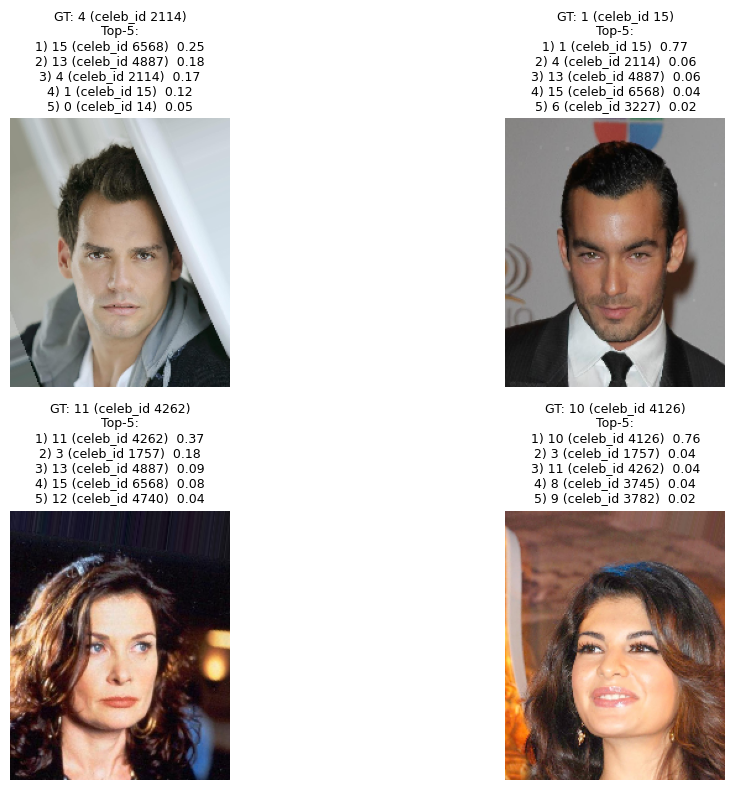

In [53]:
import torch, random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

# helper: run one PIL image through the processor+model and return top-k
def topk_predict(pil_image, k=5):
    with torch.no_grad():
        enc = processor(images=pil_image.convert("RGB"), return_tensors="pt")
        pixel_values = enc["pixel_values"].to(device)          # (1, 3, 224, 224)
        logits = model(pixel_values=pixel_values).logits       # (1, num_labels)
        probs = torch.softmax(logits, dim=-1).squeeze(0)       # (num_labels,)
        vals, idxs = torch.topk(probs, k)
        vals = vals.cpu().numpy()
        idxs = idxs.cpu().numpy()
        # map label index -> original celeb_id string for readability
        preds_readable = [(int(idxs[i]), str(label2id[int(idxs[i])]), float(vals[i])) for i in range(k)]
        return preds_readable  # list of (label_idx, celeb_id, prob)

# try on a few random test samples and visualize
N = 4
indices = random.sample(range(len(test_ds_tf)), k=min(N, len(test_ds_tf)))

plt.figure(figsize=(12, 8))
for j, idx in enumerate(indices):
    ex = test_ds_tf[idx]
    img = ex["image"]
    true_label = int(ex["label"])
    true_celeb = str(label2id[true_label])

    preds = topk_predict(img, k=5)
    title_lines = [f"GT: {true_label} (celeb_id {true_celeb})", "Top-5:"]
    for r, (li, cid, p) in enumerate(preds, 1):
        title_lines.append(f"{r}) {li} (celeb_id {cid})  {p:.2f}")

    ax = plt.subplot(2, 2, j+1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("\n".join(title_lines), fontsize=9)

plt.tight_layout()
plt.show()


### Step 15 : Gradio demo for FaceGuard (Top-5 identity predictions)

In [54]:
import torch, gradio as gr
from PIL import Image
from transformers import AutoImageProcessor

# reuse the trained model + label mapping you already have in memory
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ensure we have a processor in this cell
MODEL_NAME = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

# build readable class names: index -> celeb_id string
class_names = [str(label2id[i]) for i in range(num_labels)]

def predict_top5(img: Image.Image):
    """Return a dict {class_name: probability} that Gradio's Label can show as Top-k."""
    if img is None:
        return {}
    img = img.convert("RGB")
    with torch.no_grad():
        inputs = processor(images=img, return_tensors="pt").to(device)
        logits = model(pixel_values=inputs["pixel_values"]).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

    # Top-5 indices
    top5_idx = probs.argsort()[-5:][::-1]
    # Gradio's Label expects a dict of {name: score} (it will auto-sort)
    return {f"label {i}  (celeb_id {class_names[i]})": float(probs[i]) for i in top5_idx}

demo = gr.Interface(
    fn=predict_top5,
    inputs=gr.Image(type="pil", label="Upload a face image"),
    outputs=gr.Label(num_top_classes=5, label="Top-5 identities"),
    title="FaceGuard — ViT (Top-5 identity predictions)",
    description="Model: google/vit-base-patch16-224 (fine-tuned on 20 CelebA identities). "
                "Shows the Top-5 predicted labels with probabilities.",
    allow_flagging="never",
)

# Optional: add 2–3 test examples pulled from your test set (fast preview)
def _example(i):
    ex = test_ds_tf[i]
    return ex["image"]

examples = []
for i in range(min(3, len(test_ds_tf))):
    examples.append(_example(i))

if examples:
    demo.examples = examples

demo.launch(debug=False)  # In HF Spaces, set share=False (default). In Colab, this opens a link.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:414: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2504da89d4f54a052.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Step 16:. Workflow to export
1. Export your trained model

In [55]:
trainer.save_model("faceguard_model")
processor.save_pretrained("faceguard_model")


['faceguard_model/preprocessor_config.json']

2. Push to Hub (model repo, so you can reuse it in your Space):

In [58]:
from huggingface_hub import notebook_login
notebook_login()   # enter your HF token (write access)

from huggingface_hub import HfApi
api = HfApi()
api.create_repo("FaceGuard-20ID-ViT", repo_type="model", exist_ok=True)

model.push_to_hub("hudaakram/FaceGuard-20ID-ViT")
processor.push_to_hub("hudaakram/FaceGuard-20ID-ViT")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpuilub8d9/model.safetensors    :   0%|          |  553kB /  343MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hudaakram/FaceGuard-20ID-ViT/commit/eeebc47262f4618489bd33c1cbb1e35fe8c512cd', commit_message='Upload processor', commit_description='', oid='eeebc47262f4618489bd33c1cbb1e35fe8c512cd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hudaakram/FaceGuard-20ID-ViT', endpoint='https://huggingface.co', repo_type='model', repo_id='hudaakram/FaceGuard-20ID-ViT'), pr_revision=None, pr_num=None)

3.Create a Space (Gradio app):

In [59]:
api.create_repo("FaceGuard-demo", repo_type="space", space_sdk="gradio", exist_ok=True)

RepoUrl('https://huggingface.co/spaces/hudaakram/FaceGuard-demo', endpoint='https://huggingface.co', repo_type='space', repo_id='hudaakram/FaceGuard-demo')

Step 17: Tiny tweak for Space deployment

In [61]:
from transformers import ViTForImageClassification, AutoImageProcessor

MODEL_ID = "hudaakram/FaceGuard-20ID-ViT"
model = ViTForImageClassification.from_pretrained(MODEL_ID)
processor = AutoImageProcessor.from_pretrained(MODEL_ID)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

### Step 18:you can uncomment and copy and paste these in your space"

1.app.py

In [65]:
# import gradio as gr
# import torch
# from PIL import Image
# from transformers import ViTForImageClassification, AutoImageProcessor

# MODEL_ID = "hudaakram/FaceGuard-20ID-ViT"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ViTForImageClassification.from_pretrained(MODEL_ID).to(device).eval()
# processor = AutoImageProcessor.from_pretrained(MODEL_ID)

# id2label = {int(k): v for k, v in model.config.id2label.items()}

# def predict_top5(img: Image.Image):
#     if img is None:
#         return {}
#     with torch.no_grad():
#         enc = processor(images=img.convert("RGB"), return_tensors="pt").to(device)
#         logits = model(pixel_values=enc["pixel_values"]).logits
#         probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
#     top5 = probs.argsort()[-5:][::-1]
#     return {f"label {i} (celeb_id {id2label[i]})": float(probs[i]) for i in top5}

# demo = gr.Interface(
#     fn=predict_top5,
#     inputs=gr.Image(type="pil", label="Upload a face image"),
#     outputs=gr.Label(num_top_classes=5, label="Top-5 identities"),
#     title="FaceGuard – ViT (20 CelebA IDs)",
#     description="Upload a face image. Model is ViT-base fine-tuned on 20 CelebA IDs. Outputs Top-5 predicted celeb_id values.",
#     allow_flagging="never",
# )

# if __name__ == "__main__":
#     demo.launch()


2.requirements.txt

In [66]:
# transformers==4.56.1
# torch
# torchvision
# gradio>=4.0.0
# Pillow
# numpy


3. README.md

In [ ]:
# # FaceGuard – ViT (20 CelebA IDs)

# A lightweight face-identity classifier demo.

# - **Backbone:** google/vit-base-patch16-224 (pretrained on ImageNet-1k)
# - **Fine-tuned on:** 20 CelebA identities (chosen by frequency)
# - **Accuracy:** ~83% on test set (77 images)
# - **Metrics:** Confusion matrix + ROC available below

# ## Demo
# Try the Space here 👉 https://huggingface.co/spaces/hudaakram/FaceGuard-demo

# ## How it works
# 1. Upload a face crop.
# 2. Model preprocesses via ViT image processor (224×224 normalize).
# 3. Outputs Top-5 predicted identities (IDs are CelebA integer labels, not names).

# ## Visuals
# ![Confusion Matrix](./confusion_matrix_test.png)
# ![ROC Curves](./roc_curves_test.png)

# ---

# ⚠️ Note: This is for research/demo only. The CelebA IDs are anonymous numbers (not celebrity names).


##or run this:

In [68]:
# 🚀 One-shot deploy to Hugging Face Space (with proper README config)
from pathlib import Path
from huggingface_hub import whoami, HfApi
import os, shutil

# --- settings ---
MODEL_ID = "hudaakram/FaceGuard-20ID-ViT"   # your pushed model
SPACE_NAME = "FaceGuard-demo"               # repo name for the Space

me = whoami()
username = me["name"]
SPACE_ID = f"{username}/{SPACE_NAME}"
api = HfApi()

# ensure the Space exists (Gradio SDK)
api.create_repo(repo_id=SPACE_ID, repo_type="space", space_sdk="gradio", exist_ok=True)

# --------- write files locally ---------
root = Path("faceguard_space"); root.mkdir(exist_ok=True)

APP = f"""\
import gradio as gr
import torch
from PIL import Image
from transformers import ViTForImageClassification, AutoImageProcessor

MODEL_ID = "{MODEL_ID}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTForImageClassification.from_pretrained(MODEL_ID).to(device).eval()
processor = AutoImageProcessor.from_pretrained(MODEL_ID)

# readable class names from config (id2label maps idx -> celeb_id string)
id2label = {{int(k): v for k, v in model.config.id2label.items()}}

def predict_top5(img: Image.Image):
    if img is None:
        return {{}}
    img = img.convert("RGB")
    with torch.no_grad():
        enc = processor(images=img, return_tensors="pt").to(device)
        logits = model(pixel_values=enc["pixel_values"]).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()
    top5 = probs.argsort()[-5:][::-1]  # indices of Top-5 classes
    return {{f"label {{i}} (celeb_id {{id2label[i]}})": float(probs[i]) for i in top5}}

desc = (
    "FaceGuard — Vision Transformer (google/vit-base-patch16-224) fine-tuned on a 20-identity subset of CelebA.\\n"
    "Upload a face crop to see the Top-5 predicted identities. (IDs are CelebA celeb_id integers.)"
)

demo = gr.Interface(
    fn=predict_top5,
    inputs=gr.Image(type="pil", label="Upload a face image"),
    outputs=gr.Label(num_top_classes=5, label="Top-5 identities"),
    title="FaceGuard – ViT (20 CelebA IDs)",
    description=desc,
    allow_flagging="never",
)

if __name__ == "__main__":
    demo.launch()
"""

REQ = """\
transformers==4.56.1
torch
torchvision
gradio>=4.0.0
Pillow
numpy
"""

README = f"""\
---
title: FaceGuard – ViT Demo
emoji: 🎭
colorFrom: indigo
colorTo: pink
sdk: gradio
sdk_version: "4.0.0"
app_file: app.py
pinned: false
---

# FaceGuard – ViT (20 CelebA IDs)

A lightweight face-identity classifier demo.

- **Backbone:** `google/vit-base-patch16-224` (pretrained on ImageNet-1k)
- **Fine-tuned model:** [{MODEL_ID}](https://huggingface.co/{MODEL_ID})
- **Classes:** 20 CelebA `celeb_id` identities (top-20 by count)
- **Split:** 80/10/10 stratified
- **Test accuracy:** ~83% on a held-out set (77 images)

## Try it
This Space lets you upload a face crop and see **Top-5 predicted identities**.
*Note:* CelebA identities are anonymous integer IDs (e.g., 8968), not real names.

## Visuals
![Confusion Matrix](./confusion_matrix_test.png)
![ROC Curves](./roc_curves_test.png)

## Tech
- 🤗 Transformers (ViT), 🤗 Datasets, Gradio UI
"""

# write files
(root / "app.py").write_text(APP, encoding="utf-8")
(root / "requirements.txt").write_text(REQ, encoding="utf-8")
(root / "README.md").write_text(README, encoding="utf-8")

# copy plots if they exist
plots_src = "artifacts_faceguard"
if os.path.exists(plots_src):
    for fname in ["confusion_matrix_test.png", "roc_curves_test.png"]:
        src = Path(plots_src) / fname
        if src.exists():
            shutil.copy(src, root / fname)

print("Prepared files:", [p.name for p in root.iterdir()])

# --------- upload to Space ---------
api.upload_folder(
    repo_id=SPACE_ID,
    repo_type="space",
    folder_path=str(root),
    path_in_repo=".",
    commit_message="Deploy FaceGuard demo with proper README config"
)

print("✅ Space updated:", f"https://huggingface.co/spaces/{SPACE_ID}")


Prepared files: ['README.md', 'confusion_matrix_test.png', 'roc_curves_test.png', 'requirements.txt', 'app.py']


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...faceguard_space/roc_curves_test.png: 100%|##########|  143kB /  143kB            

✅ Space updated: https://huggingface.co/spaces/hudaakram/FaceGuard-demo
